# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, avg, stddev, split, isnull, first, when, last, 
from pyspark.sql.functions import col, format_number, rand, countDistinct, count, desc
from pyspark.sql.functions import sum as s_sum
from pyspark.sql.functions import max as s_max
from pyspark.sql.functions import min as s_min
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc

import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_Data") \
    .getOrCreate()

# A. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## 1. Load

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
len(df.columns)

18

In [5]:
df.count()

286500

In [6]:
df.describe('userId').show()
df.describe('sessionId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



There are 18 columns and 286,500 rows in our dataset. Among those columns, columns named `userId` and `sessionId` will play important role as the key.

## 2. Cleansing

From above `df.describe(userId).show()`, we could find that it's minimum value is little awkward. Let's find and delete NaNs and empty strings.

In [7]:
print('---- NaN values in each columns')
for col in df.columns:
    print('{}: {}'.format(col, df.filter(isnull(df[col])).count()))
    
print('---------------------------------')
print('---- Empty strings in each columns')
for col in df.columns:
    print('{}: {}'.format(col, df.filter(df[col]=='').count()))

---- NaN values in each columns
artist: 58392
auth: 0
firstName: 8346
gender: 8346
itemInSession: 0
lastName: 8346
length: 58392
level: 0
location: 8346
method: 0
page: 0
registration: 8346
sessionId: 0
song: 58392
status: 0
ts: 0
userAgent: 8346
userId: 0
---------------------------------
---- Empty strings in each columns
artist: 0
auth: 0
firstName: 0
gender: 0
itemInSession: 0
lastName: 0
length: 0
level: 0
location: 0
method: 0
page: 0
registration: 0
sessionId: 0
song: 0
status: 0
ts: 0
userAgent: 0
userId: 8346


We saw 8,346 empty strings in `userId`, so let's delete these.

In [8]:
df_cleaned = df.filter(df['userId']!='')
df_cleaned.count()

278154

Also, like in the lecture, we should correct the type of `ts` column. Its type should be `datetime`, so we'll make additional datetime column named `time`.

In [9]:
change_into_dt = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
df_cleaned = df_cleaned.withColumn("time", change_into_dt(df_cleaned.ts))

In [10]:
df_cleaned.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)



In [11]:
df_cleaned

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, time: string]

# B. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## 1. Basic EDA

First, let's do basic eda. We'll verify numerical and categorical columns each.

In [12]:
# df_cleaned.createOrReplaceGlobalTempView("Sparkify_Data_cleaned")

In [13]:
numerical_cols = []
categoric_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        categoric_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        numerical_cols.append(s.name)

### 1-1. Numerical Columns

In [14]:
numerical_cols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [15]:
df_cleaned.describe(numerical_cols).show()

+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|         sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|           228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.1171819778458|1.535358834084427...|1042.5616241362698|209.10321620397335|1.540958915431871...|
| stddev|  129.851729399489|99.23517921058361| 3.291321616327586E9| 726.5010362219813|30.151388851328214|1.5068287123306298E9|
|    min|                 0|          0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|              2474|               404|      

In [16]:
df_cleaned.select("status") \
     .groupBy("status") \
     .agg({'status' : 'count'}) \
     .withColumnRenamed('count(status)', 'status_cnt') \
     .sort(desc('status_cnt')) \
     .show()

+------+----------+
|status|status_cnt|
+------+----------+
|   200|    254718|
|   307|     23184|
|   404|       252|
+------+----------+



There are 3 status in our dataset. Each of them means  
- 307: Temporary Redirect
- 404: Not Found
- 200: OK

The distribution of `length` is right skewed.

In [17]:
df_cleaned.select("ts") \
     .groupBy("ts") \
     .agg({'ts' : 'count'}) \
     .withColumnRenamed('count(ts)', 'ts_cnt') \
     .sort(desc('ts_cnt')) \
     .show()

+-------------+------+
|           ts|ts_cnt|
+-------------+------+
|1543376608000|     4|
|1538786140000|     4|
|1538832860000|     3|
|1540869687000|     3|
|1543271891000|     3|
|1542848987000|     3|
|1538858551000|     3|
|1541682160000|     3|
|1539070175000|     3|
|1538512769000|     3|
|1539191076000|     3|
|1539996675000|     3|
|1542663435000|     3|
|1541518229000|     3|
|1541544871000|     3|
|1539682547000|     3|
|1541101796000|     3|
|1539247652000|     3|
|1539721234000|     3|
|1540456067000|     3|
+-------------+------+
only showing top 20 rows



`ts` seems to be time stamp.

### 1-2. Categorical Columns

In [18]:
categoric_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

Let's see their distribution briefly.

In [19]:
for col in ['auth', 'gender', 'level', 'method', 'page']:
#     df_cleaned.select(col).dropDuplicates().show()
    df_cleaned.select(col) \
         .groupBy(col) \
         .agg({col : 'count'}) \
         .withColumnRenamed('count({})'.format(col), '{}_cnt'.format(col)) \
         .sort(desc('{}_cnt'.format(col))) \
         .show()

+---------+--------+
|     auth|auth_cnt|
+---------+--------+
|Logged In|  278102|
|Cancelled|      52|
+---------+--------+

+------+----------+
|gender|gender_cnt|
+------+----------+
|     F|    154578|
|     M|    123576|
+------+----------+

+-----+---------+
|level|level_cnt|
+-----+---------+
| paid|   222433|
| free|    55721|
+-----+---------+

+------+----------+
|method|method_cnt|
+------+----------+
|   PUT|    257818|
|   GET|     20336|
+------+----------+

+--------------------+--------+
|                page|page_cnt|
+--------------------+--------+
|            NextSong|  228108|
|           Thumbs Up|   12551|
|                Home|   10082|
|     Add to Playlist|    6526|
|          Add Friend|    4277|
|         Roll Advert|    3933|
|              Logout|    3226|
|         Thumbs Down|    2546|
|           Downgrade|    2055|
|            Settings|    1514|
|                Help|    1454|
|             Upgrade|     499|
|               About|     495|
|       Sa

Maybe we should focus on **`Cancellation Conf...`** and **`Downgrade`** to think about churn.

Let's see how many users in our dataset and how many users have paid to sparkify.

In [20]:
n_users = df_cleaned.select('userId').dropDuplicates().count()
n_users_paid = df_cleaned.select(['userId', 'level']) \
                        .filter(df_cleaned['level']=='paid') \
                        .select('userId') \
                        .dropDuplicates() \
                        .count()
n_users_free = df_cleaned.select(['userId', 'level']) \
                        .filter(df_cleaned['level']=='free') \
                        .select('userId') \
                        .dropDuplicates() \
                        .count()

print('# of users: {}'.format(n_users))
print('# of paid users: {}'.format(n_users_paid))
print('# of free users: {}'.format(n_users_free))

# of users: 225
# of paid users: 165
# of free users: 195


There are 225 users in our dataset. We could also see that users who have both paid and free level, because 225!=165+195. Let's see them.

In [21]:
df_cleaned.filter(df_cleaned['level']=='free') \
        .select('userId').dropDuplicates() \
        .intersect(
            df_cleaned.filter(df_cleaned['level']=='paid') \
            .select('userId').dropDuplicates() \
            ) \
        .count()

135

It seems that there are 135 users who experienced both paid and free level in our app.

### 1-3. See how specific user's log looks like

Since there are too many rows to see at once, we'll limit first 1,000 rows only to see specific user's log.

In [22]:
df_cleaned.select('userId').show()

+------+
|userId|
+------+
|    30|
|     9|
|    30|
|     9|
|    30|
|     9|
|     9|
|    30|
|    30|
|    30|
|     9|
|     9|
|    30|
|     9|
|     9|
|    30|
|     9|
|    74|
|    30|
|     9|
+------+
only showing top 20 rows



In [23]:
df_cleaned.limit(1000) \
        .select(['page', 'userId', 'auth', 'status', 'level', 'song'])\
        .where(df_cleaned.userId == '30').show()

+---------------+------+---------+------+-----+--------------------+
|           page|userId|     auth|status|level|                song|
+---------------+------+---------+------+-----+--------------------+
|       NextSong|    30|Logged In|   200| paid|           Rockpools|
|       NextSong|    30|Logged In|   200| paid|   Time For Miracles|
|       NextSong|    30|Logged In|   200| paid|Harder Better Fas...|
|       NextSong|    30|Logged In|   200| paid|Passengers (Old A...|
|Add to Playlist|    30|Logged In|   200| paid|                null|
|       NextSong|    30|Logged In|   200| paid|          Fuck Kitty|
|       NextSong|    30|Logged In|   200| paid|                Jade|
|       NextSong|    30|Logged In|   200| paid|   So-Called Friends|
|       NextSong|    30|Logged In|   200| paid|           Represent|
|       NextSong|    30|Logged In|   200| paid|           Here I Am|
|       NextSong|    30|Logged In|   200| paid|Rebirthing (Album...|
|       NextSong|    30|Logged In|

We could see various behavior of each user like above. Among behaviors, we should focus on **how `level` changed from `paid` into `free`** to think about churn.

## 2. Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

To define new variable `churn`, we'll use `Cancellation Confirmation` value in `page` column.

In [24]:
churn_users = df_cleaned.filter(df_cleaned.page == "Cancellation Confirmation") \
                .select("userId").dropDuplicates().collect()
churn_user_lst = [str(row.userId) for row in churn_users]

In [25]:
df_cleaned_stmp = df_cleaned.withColumn('churn', 
                                        when(df_cleaned.userId.isin(churn_user_lst), 1) \
                                        .otherwise(0))

Let's see how many users have canceled their subscription.

In [26]:
churn_O_users = df_cleaned_stmp.filter(df_cleaned_stmp['churn']==1) \
                                .select('userId').dropDuplicates()
churn_X_users = df_cleaned_stmp.filter(df_cleaned_stmp['churn']==0) \
                                .select('userId').dropDuplicates()

In [27]:
print('User counts / churn--------')
print('O: {}'.format(churn_O_users.count()))
print('X: {}'.format(churn_X_users.count()))

User counts / churn--------
O: 52
X: 173


There are 52 users who canceled the service.

## 3. Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for **users who stayed vs users who churned.** You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [28]:
df_cleaned_stmp.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churn: integer (nullable = false)



### 3-1. Artist

We'll count how many artists in `NextSong` page, because we thought this could affect to churn.

In [29]:
cnt_artist = df_cleaned_stmp.filter(df_cleaned_stmp['page']=='NextSong') \
                            .groupby(['userId', 'churn']) \
                            .agg(count('artist').alias('artist_whole'), 
                                 countDistinct('artist').alias('artist_uniq'))

cnt_artist.show(10)

+------+-----+------------+-----------+
|userId|churn|artist_whole|artist_uniq|
+------+-----+------------+-----------+
|    19|    0|         216|        197|
|100005|    1|         154|        149|
|300007|    1|         111|        107|
|200007|    0|          65|         64|
|    50|    0|         503|        423|
|200002|    0|         387|        339|
|    30|    0|        1417|       1018|
|     8|    0|         251|        230|
|100012|    1|         476|        397|
|100011|    1|          11|         11|
+------+-----+------------+-----------+
only showing top 10 rows



We could see the average number of artists also.

In [30]:
avg_artist = cnt_artist.groupby('churn') \
                        .agg({'artist_whole':'mean', 'artist_uniq':'mean'})
avg_artist.show(3)

+-----+-----------------+------------------+
|churn| avg(artist_uniq)| avg(artist_whole)|
+-----+-----------------+------------------+
|    1|518.6923076923077| 699.8846153846154|
|    0|749.7861271676301|1108.1734104046243|
+-----+-----------------+------------------+



We could say that **churn users seem to listen less artists than normal users**.

### 3-2. Auth

In [31]:
df_cleaned_stmp.select(['page', 'userId', 'auth', 'status', 'level', 'churn']) \
            .filter(df_cleaned_stmp['churn']==1).show()

+---------+------+---------+------+-----+-----+
|     page|userId|     auth|status|level|churn|
+---------+------+---------+------+-----+-----+
| NextSong|    54|Logged In|   200| paid|    1|
| NextSong|    54|Logged In|   200| paid|    1|
| NextSong|    54|Logged In|   200| paid|    1|
| NextSong|    54|Logged In|   200| paid|    1|
|Downgrade|    54|Logged In|   200| paid|    1|
| NextSong|    54|Logged In|   200| paid|    1|
| NextSong|    54|Logged In|   200| paid|    1|
|Thumbs Up|    54|Logged In|   307| paid|    1|
|     Home|   101|Logged In|   200| free|    1|
| NextSong|   101|Logged In|   200| free|    1|
| NextSong|   101|Logged In|   200| free|    1|
| NextSong|   101|Logged In|   200| free|    1|
| NextSong|   101|Logged In|   200| free|    1|
| NextSong|   101|Logged In|   200| free|    1|
|     Help|   101|Logged In|   200| free|    1|
| NextSong|   101|Logged In|   200| free|    1|
| NextSong|   101|Logged In|   200| free|    1|
| NextSong|   101|Logged In|   200| free

In [32]:
to_see_auth = df_cleaned_stmp.filter(df_cleaned_stmp['churn']==1) \
                            .select(['userId', 'page', 'auth']) \
                            .dropDuplicates()

to_see_auth.groupBy('page').count().show()
to_see_auth.groupBy('auth').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   52|
|    Submit Downgrade|    9|
|         Thumbs Down|   48|
|                Home|   51|
|           Downgrade|   35|
|         Roll Advert|   50|
|              Logout|   46|
|       Save Settings|   30|
|Cancellation Conf...|   52|
|               About|   31|
|            Settings|   43|
|     Add to Playlist|   50|
|          Add Friend|   44|
|            NextSong|   52|
|           Thumbs Up|   50|
|                Help|   43|
|             Upgrade|   37|
|               Error|   22|
|      Submit Upgrade|   29|
+--------------------+-----+

+---------+-----+
|     auth|count|
+---------+-----+
|Cancelled|   52|
|Logged In|  722|
+---------+-----+



It seems that the all user who is in the page `Cancellation Confirmation` has `Cancelled` auth value. So we decided to drop this column. 

In [33]:
df_cleaned_stmp = df_cleaned_stmp.drop('auth')
del to_see_auth

### 3-3. firstName, lastName, gender

Maybe among demographic columns(including `location`), two features related to name are too unique. So we'll drop them also.

In [34]:
df_cleaned_stmp = df_cleaned_stmp.drop('firstName')
df_cleaned_stmp = df_cleaned_stmp.drop('lastName')
df_cleaned_stmp.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churn: integer (nullable = false)



Let's see `gender` features.

In [35]:
df_cleaned_stmp.groupby('gender').agg({'churn':'mean'}).show()

+------+-------------------+
|gender|         avg(churn)|
+------+-------------------+
|     F|0.12400212190609272|
|     M|0.20793681621026736|
+------+-------------------+



In [36]:
to_see_gender = df_cleaned_stmp.groupby(['gender', 'userId']) \
                                .agg({'churn':'mean'})

to_see_gender.groupby('gender').agg({'avg(churn)':'mean'}).show()

+------+-------------------+
|gender|    avg(avg(churn))|
+------+-------------------+
|     F|0.19230769230769232|
|     M| 0.2644628099173554|
+------+-------------------+



**Female users tend to settle down to our service than male users.**

### 3-4. itemInSession

This feature is also just a number for items in session, we'll drop this also.

In [37]:
df_cleaned_stmp = df_cleaned_stmp.drop('itemInSession')

### 3-5. length

We thought that this feature have important role for predicting churn. We'll analyze average listening duration. Let's get the aggregated length sum of each user first.

In [38]:
to_see_length = df_cleaned_stmp.filter(df_cleaned_stmp['page']=='NextSong') \
                                .groupby(['userId', 'churn']) \
                                .agg({'length':'sum'})
to_see_length.show(10)

+------+-----+------------------+
|userId|churn|       sum(length)|
+------+-----+------------------+
|    19|    0|54480.933869999986|
|100005|    1| 37037.12201000001|
|200007|    0|15739.869310000002|
|300007|    1| 28028.71048000002|
|    50|    0|122751.27560999991|
|200002|    0| 94008.87593999993|
|    30|    0| 359808.2456399997|
|     8|    0| 63393.53190999996|
|100011|    1|         2841.6995|
|100012|    1|115503.35311000001|
+------+-----+------------------+
only showing top 10 rows



Next we'll calculate the average of length sum.

In [39]:
to_see_length.groupby('churn').agg({'sum(length)':'mean'}).show()

+-----+------------------+
|churn|  avg(sum(length))|
+-----+------------------+
|    1| 174014.2685513462|
|    0|276166.93746780336|
+-----+------------------+



**We could see that churns tend to play less songs than others!**

### 3-6. level

Whether `level` feature has changed from `paid` to `free` or not may play crucial role. To analyze this, we'll investigate the very last `level` feature of each users before changed into churn.

In [40]:
to_see_level = df_cleaned_stmp.groupby(['userId', 'churn']) \
                            .agg(last('level').alias('level_last'),
                                 count('level').alias('level_cnt'))
to_see_level.show(15)

+------+-----+----------+---------+
|userId|churn|level_last|level_cnt|
+------+-----+----------+---------+
|    19|    0|      paid|      259|
|100005|    1|      free|      216|
|200007|    0|      paid|       76|
|300007|    1|      paid|      143|
|200002|    0|      paid|      474|
|    50|    0|      paid|      651|
|100011|    1|      free|       23|
|100012|    1|      free|      600|
|    30|    0|      paid|     1775|
|     8|    0|      free|      334|
|     4|    0|      paid|     2442|
|    65|    0|      paid|     2544|
|   101|    1|      paid|     2149|
|    13|    0|      free|     1654|
|   153|    0|      paid|     1131|
+------+-----+----------+---------+
only showing top 15 rows



In [41]:
to_see_level.groupby('level_last').agg({'churn':'mean'}).show()

+----------+-------------------+
|level_last|         avg(churn)|
+----------+-------------------+
|      free|             0.2625|
|      paid|0.21379310344827587|
+----------+-------------------+



It seems that about 26% of free users and 21% of paid users experienced churn.

### 3-7. location

In [42]:
to_see_loc = df_cleaned_stmp.groupby(['userId', 'location']) \
                            .agg(avg('churn').alias('churn_avg'))
to_see_loc.show(10)

+------+--------------------+---------+
|userId|            location|churn_avg|
+------+--------------------+---------+
|    86|    Jacksonville, FL|      0.0|
|    14|        Syracuse, NY|      0.0|
|    77|     Gainesville, FL|      0.0|
|200007|New York-Newark-J...|      0.0|
|    46|Los Angeles-Long ...|      0.0|
|    70|         Jackson, MS|      1.0|
|300012|Miami-Fort Lauder...|      0.0|
|    96|Atlantic City-Ham...|      0.0|
|    90|Seattle-Tacoma-Be...|      0.0|
|    54|Spokane-Spokane V...|      1.0|
+------+--------------------+---------+
only showing top 10 rows



We should see whether there's a difference in churn rate between locations or not.

In [43]:
loc_churn_rate = to_see_loc.groupby('location').agg(avg('churn_avg').alias('churn_rate'))
loc_churn_rate.show(5)

+--------------------+------------------+
|            location|        churn_rate|
+--------------------+------------------+
|     Gainesville, FL|               0.0|
|Atlantic City-Ham...|               0.0|
|San Diego-Carlsba...|0.3333333333333333|
|Deltona-Daytona B...|               0.0|
|Cleveland-Elyria, OH|               1.0|
+--------------------+------------------+
only showing top 5 rows



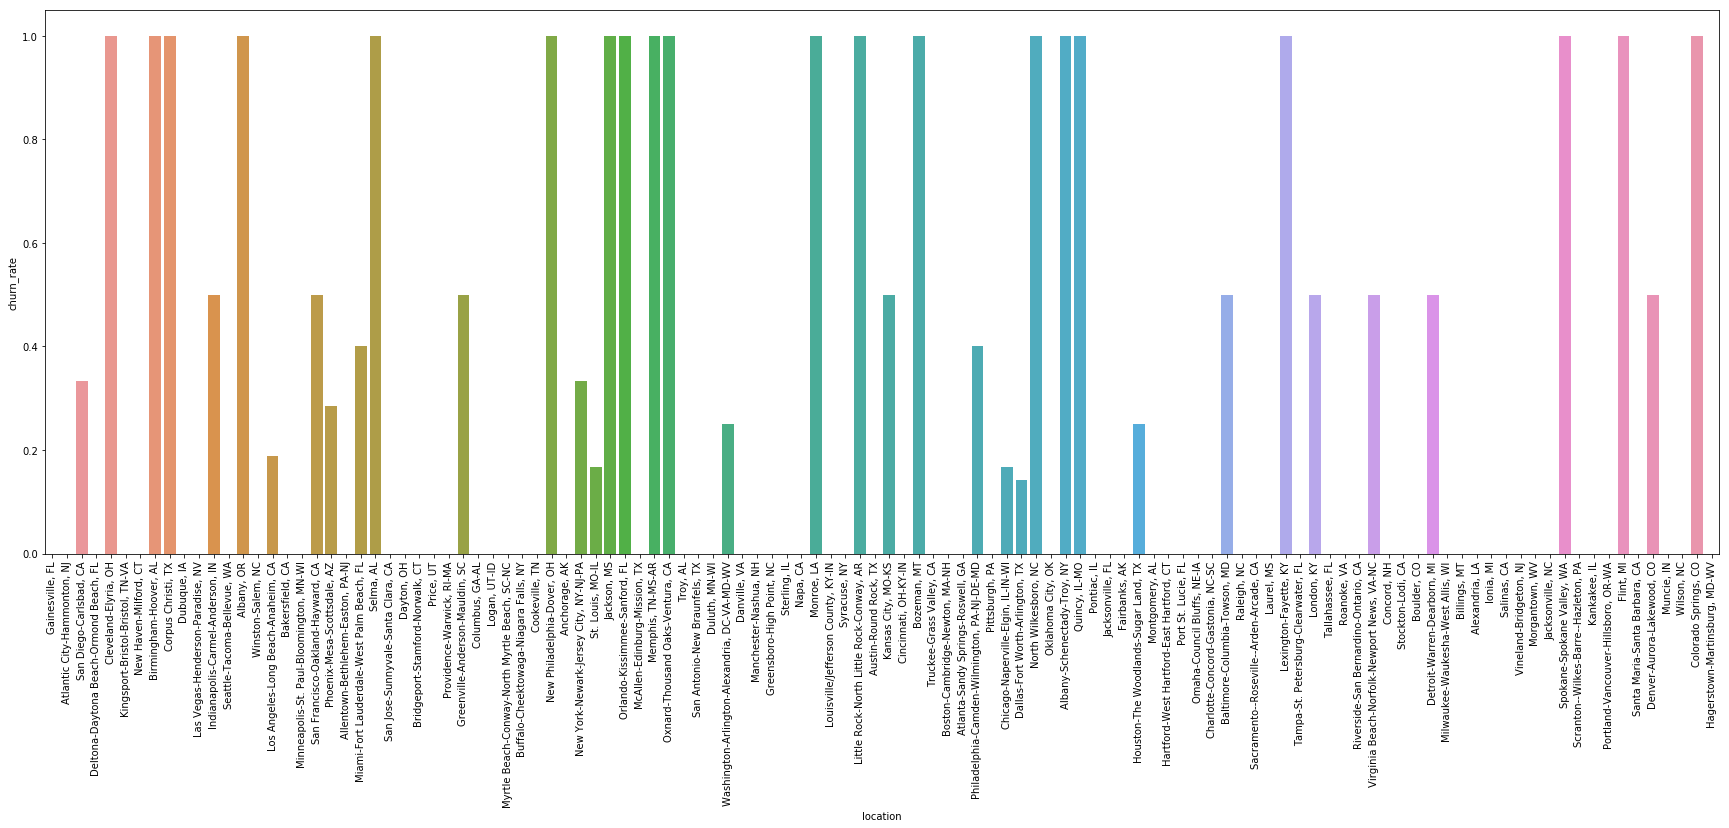

In [44]:
fig = plt.figure(figsize = (30,10))
sns.barplot(x = 'location', y = 'churn_rate', data = loc_churn_rate.toPandas())
plt.xticks(rotation = 90)
plt.show()

Definitely there's a difference between locations.

### 3-8. method

This is also meaningless, so we'll drop this too.

In [45]:
df_cleaned_stmp = df_cleaned_stmp.drop('method') 

### 3-9. page

Maybe this column is critical, so we'll make the pivot of this and investigate.

In [46]:
page_pivot = df_cleaned_stmp.groupby(['userId', 'churn']).pivot('page').count()

## Drop columns related directly to churn
page_pivot = page_pivot.drop('Cancel')
page_pivot = page_pivot.drop('Cancellation Confirmation')

## Fill nans
page_pivot = page_pivot.fillna(0)
## page_pivot.show(5) is not much readable, so we'll change it via pandas
page_pivot = page_pivot.toPandas()
page_pivot.head(5)

,userId,churn,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,19,0,2,4,8,2,0,0,11,8,216,0,0,1,0,0,2,5,0
1,300007,1,0,4,4,2,0,1,3,0,111,2,1,1,0,0,1,11,0
2,100005,1,0,3,3,0,0,2,15,3,154,18,0,2,0,0,3,7,4
3,200007,0,0,1,0,0,1,2,4,1,65,0,0,0,0,0,0,2,0
4,50,0,2,9,12,2,2,7,25,6,503,37,3,9,0,1,3,27,3


  Average Churn of About
churn
0    2.537572
1    1.076923
Name: About, dtype: float64


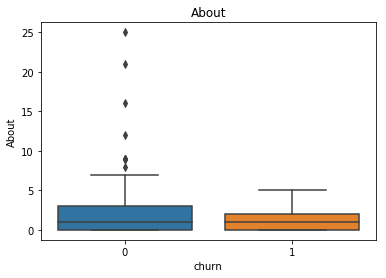

  Average Churn of Add Friend
churn
0    21.046243
1    12.230769
Name: Add Friend, dtype: float64


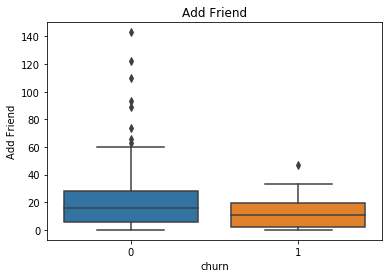

  Average Churn of Add to Playlist
churn
0    31.722543
1    19.961538
Name: Add to Playlist, dtype: float64


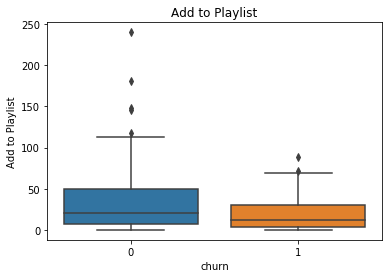

  Average Churn of Downgrade
churn
0    9.930636
1    6.480769
Name: Downgrade, dtype: float64


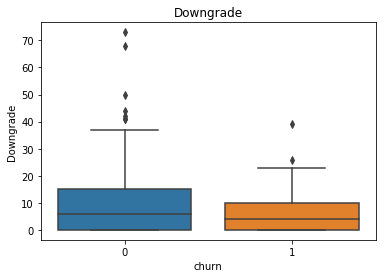

  Average Churn of Error
churn
0    1.271676
1    0.615385
Name: Error, dtype: float64


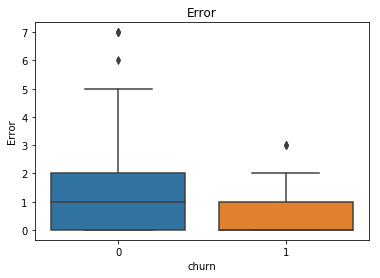

  Average Churn of Help
churn
0    7.023121
1    4.596154
Name: Help, dtype: float64


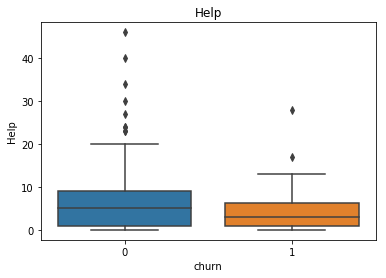

  Average Churn of Home
churn
0    48.612717
1    32.153846
Name: Home, dtype: float64


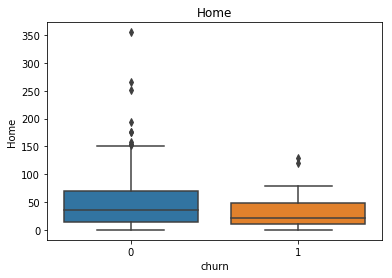

  Average Churn of Logout
churn
0    15.450867
1    10.634615
Name: Logout, dtype: float64


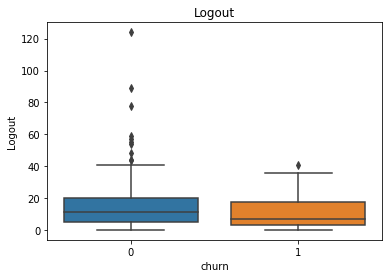

  Average Churn of NextSong
churn
0    1108.173410
1     699.884615
Name: NextSong, dtype: float64


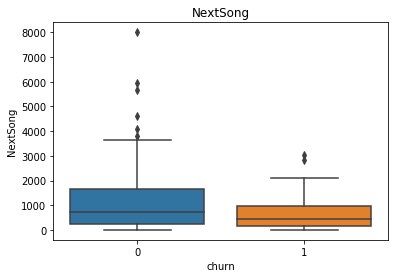

  Average Churn of Roll Advert
churn
0    17.144509
1    18.596154
Name: Roll Advert, dtype: float64


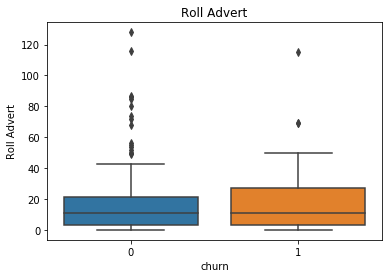

  Average Churn of Save Settings
churn
0    1.456647
1    1.115385
Name: Save Settings, dtype: float64


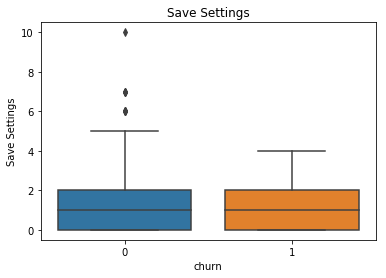

  Average Churn of Settings
churn
0    7.190751
1    5.192308
Name: Settings, dtype: float64


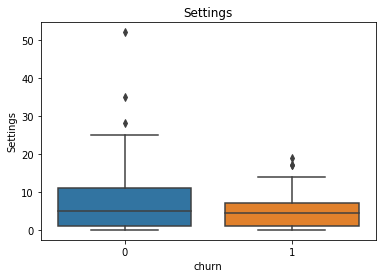

  Average Churn of Submit Downgrade
churn
0    0.312139
1    0.173077
Name: Submit Downgrade, dtype: float64


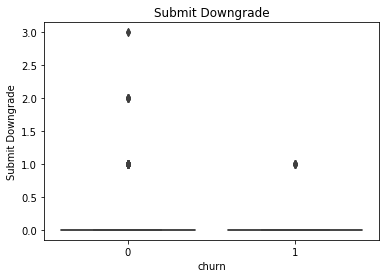

  Average Churn of Submit Upgrade
churn
0    0.734104
1    0.615385
Name: Submit Upgrade, dtype: float64


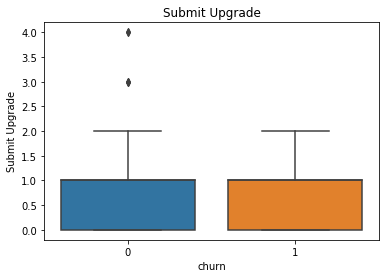

  Average Churn of Thumbs Down
churn
0    11.849711
1     9.538462
Name: Thumbs Down, dtype: float64


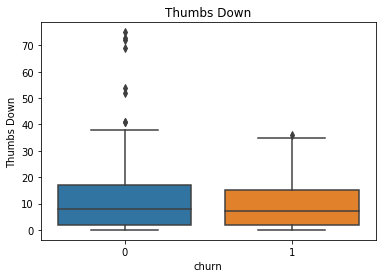

  Average Churn of Thumbs Up
churn
0    61.803468
1    35.750000
Name: Thumbs Up, dtype: float64


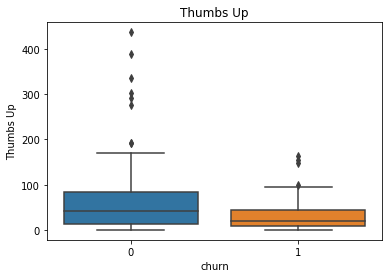

  Average Churn of Upgrade
churn
0    2.236994
1    2.153846
Name: Upgrade, dtype: float64


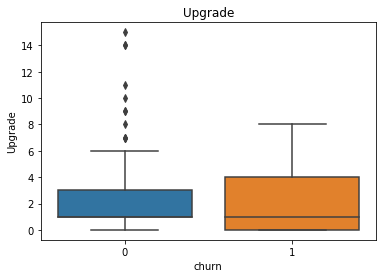

In [47]:
for col in page_pivot.columns.drop(['userId', 'churn']):
    print('=====================================')
    print(f'  Average Churn of {col}')
    print('=====================================')
    print(page_pivot[['userId', 'churn', col]].groupby('churn').mean()[col])
    sns.boxplot(x = 'churn', y = col, data = page_pivot[['userId', 'churn', col]])
    plt.title(col)
    plt.show()

In [48]:
churn_O_values = page_pivot.loc[page_pivot['churn']==1,
                                page_pivot.columns.drop(['userId', 'churn'])].mean()\
                            .rename('O')

churn_X_values = page_pivot.loc[page_pivot['churn']==0,
                                page_pivot.columns.drop(['userId', 'churn'])].mean()\
                            .rename('X')

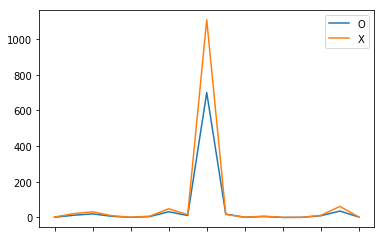

In [49]:
pd.concat([churn_O_values, churn_X_values], axis=1).plot()

From above average value and boxplots, we've noticed that

- There are definitely some differences in page values between churns and non-churns
- Both users have largest value in `Thumbs up` page (No doubt!)
- Churn users tend to have smaller values than non-churns in almost pages
- Churn users are likely to get more roll-advert
- Churn users have smaller values in `Thumbs up` and `Thumbs down` page, which means they don't interact with our service that often.

### 3-10. registration

This feature is a timestamp of registration of each users. Maybe there's a little difference between churns and non-churns(ex: oldest user among churns registered earlier than oldest non-churn). So we'll skip this.

### 3-11. song

We'll focus on songs in the page `NextSong`.

In [50]:
to_see_songs = df_cleaned_stmp.filter(df_cleaned_stmp.page == 'NextSong') \
                            .groupby(['userId', 'churn']) \
                            .agg(count('song').alias('song_cnt'),
                                 countDistinct('song').alias('song_uniq_cnt'))
to_see_songs.show(5)

+------+-----+--------+-------------+
|userId|churn|song_cnt|song_uniq_cnt|
+------+-----+--------+-------------+
|    19|    0|     216|          209|
|300007|    1|     111|          111|
|100005|    1|     154|          153|
|200007|    0|      65|           65|
|    50|    0|     503|          476|
+------+-----+--------+-------------+
only showing top 5 rows



In [51]:
to_see_songs.groupby('churn').agg(avg('song_cnt'), avg('song_uniq_cnt')).show()

+-----+------------------+------------------+
|churn|     avg(song_cnt)|avg(song_uniq_cnt)|
+-----+------------------+------------------+
|    1| 699.8846153846154| 638.3653846153846|
|    0|1108.1734104046243| 975.7687861271677|
+-----+------------------+------------------+



**Churns tend to play less songs while they use our service.**

### 3-12. status

In [52]:
df_cleaned_stmp.groupby(['userId', 'status', 'churn']) \
            .agg(count('status').alias('status_cnt')) \
            .groupby(['churn', 'status']) \
            .agg(count('status_cnt').alias('status_cnt_total')) \
            .sort('status').show()

+-----+------+----------------+
|churn|status|status_cnt_total|
+-----+------+----------------+
|    1|   200|              52|
|    0|   200|             173|
|    1|   307|              52|
|    0|   307|             171|
|    1|   404|              22|
|    0|   404|              95|
+-----+------+----------------+



In [53]:
print('Churn rate in perspective at status')
print(f'200: {round(100*52/(52+173), 2)}%')
print(f'307: {round(100*52/(52+171), 2)}%')
print(f'404: {round(100*22/(22+95), 2)}%')

Churn rate in perspective at status
200: 23.11%
307: 23.32%
404: 18.8%


### 3-13. userAgent

In [54]:
df_cleaned_stmp.select('userAgent').dropDuplicates().show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [55]:
df_cleaned_stmp.select('userAgent').dropDuplicates().count()

56

There are too many values(56) in this feature, so we should change them into small categories.

In [56]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN
    
get_browser_udf = udf(lambda x: get_browser(x))

In [57]:
df_cleaned_stmp = df_cleaned_stmp.withColumn('browser', 
                                             get_browser_udf(df_cleaned_stmp.userAgent))

In [58]:
df_cleaned_stmp.groupby(['userId', 'browser']).agg(avg('churn').alias('churn_avg')) \
               .groupby('browser').agg(avg('churn_avg').alias('churn_avg_total')).show()

+-------+-------------------+
|browser|    churn_avg_total|
+-------+-------------------+
|Firefox|               0.32|
| Safari|0.21739130434782608|
|     IE|0.08333333333333333|
| Chrome|0.21367521367521367|
+-------+-------------------+



Users using Firefox browser are likely to be churn among 4 browsers. Users using Safari and Chrome have similar value, and users using IE are the last.

### 3-14. time

In [70]:
to_see_time = df_cleaned_stmp.groupby(['userId', 'churn'])\
                            .agg(first('ts').alias('time_first'),
                                 last('ts').alias('time_last'))
to_see_time.show(5)

+------+-----+-------------+-------------+
|userId|churn|   time_first|    time_last|
+------+-----+-------------+-------------+
|    19|    0|1539105419000|1539159711000|
|100005|    1|1538407015000|1539971825000|
|200007|    0|1539951708000|1542585306000|
|300007|    1|1538677496000|1538705338000|
|    50|    0|1538622512000|1543576568000|
+------+-----+-------------+-------------+
only showing top 5 rows



In [73]:
to_see_time_pd = to_see_time.toPandas()
to_see_time_pd['time_gap'] = to_see_time_pd['time_last'] - to_see_time_pd['time_first']
to_see_time_pd.head(5)

,userId,churn,time_first,time_last,time_gap
0,19,0,1539105419000,1539159711000,54292000
1,100005,1,1538407015000,1539971825000,1564810000
2,200007,0,1539951708000,1542585306000,2633598000
3,300007,1,1538677496000,1538705338000,27842000
4,50,0,1538622512000,1543576568000,4954056000


In [74]:
to_see_time_pd.groupby('churn').mean()['time_gap']

churn
0    4.060011e+09
1    2.031666e+09
Name: time_gap, dtype: float64

**We could see that churns usually use less time than non-churns!**